# Simulation of quantum walk dynamics

In this notebook, we investigate the dynamics of quantum walk on graphs. We implement and deploy the algorithm developed in [[arXiv:XXXX.XXXX]](). 

## 1. Preliminary: classical random walk on graphs

A discrete classical random walk on an undirected graph $G=(V, E)$ describes the dynamics where a walker on a vertex uniformly chooses a neighboring vertex and transits to it. The continuous version then transits with probability $\Delta t$ for each time segment $\Delta t$ where $\Delta t\rightarrow 0$. Formally, we define $G$'s Laplacian $L$ by $$L_{jk}=\begin{cases}
  -1, & j\neq k, (j, k)\in E \\ 0, & j\neq k, (j, k)\not\in E \\ \mathrm{deg}(j), & j=k 
\end{cases}.$$
Here $\mathrm{deg}$ represents the degree of vertices. Let a vector $\mathbf{v}(t)$ represent the probability distribution of observing the walker on a vertex at time $t$. The continuous dynamics of the classical walk is characterized by an ordinary differential equation $$\frac{\mathrm{d}}{\mathrm{d}t}\mathbf{v}(t)=-L\mathbf{v}(t).$$ The solution to this equation is then described by $$\mathbf{v}(t)=e^{-Lt}\mathbf{v}(0).$$

## 2. Quantum walk on graphs

Mimicking the classical dynamics of random walk, we may also study the quantum dynamics of a quantum walk on the graph. We substitute $|\psi(t)\rangle$ for the probability distribution $\mathbf{v}$, and switch the ODE to the Schrodinger's equation $$\frac{\mathrm{d}}{\mathrm{d}t}|\psi(t)\rangle=-iL|\psi(t)\rangle.$$
Effectively, we need to simulate the Hamiltonian $L$ on quantum computers. Assume that the simulation time $T=2$. 

We consider a specific graph and its quantum walk. For simplicity, we choose chain graphs. An example chain graph containing 5 vertices is
<div> <img src="imgs/walk_chain.png" width="300"/> </div> 
Its Laplacian can be represented by 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

def mat_print(M, width=7):
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if abs(M[i, j]) < 1e-5:
                print(" " * width, end="")
            elif M.dtype == np.dtype("complex128") and abs(M[i, j].imag) < 1e-5:
                print("{f: {w}}".format(f=M[i, j].real, w=width), end="")
            else:
                print("{f: {w}}".format(f=M[i, j], w=width), end="")
        print()

N, T = 5, 2
E = np.zeros((N, N))
for j in range(N - 1):
    E[j, j + 1] = 1
A = E + E.transpose()
L_chain = np.diag(sum(A)) - A
mat_print(L_chain)

    1.0   -1.0                     
   -1.0    2.0   -1.0              
          -1.0    2.0   -1.0       
                 -1.0    2.0   -1.0
                        -1.0    1.0


### Simulate $L$ by Pauli decomposition

A naive algorithm to simulate the quantum walk is to encode the graph information $L$ directly. Specifically, we may calculate the matrix $L$ and its Pauli decomposition $$L=\sum\nolimits_{P\in\mathrm{Pauli}^{\otimes N}}\mathrm{tr}\{LP\} P.$$ Here $\mathrm{Pauli}=\{I, X, Y, Z\}$ is the set of Pauli matrices and $\mathrm{tr}$ is the trace. Then we may use Trotterization to simulate Hamiltonian $L$ by sequentially evolve $e^{-i\Delta tP}$ for Pauli tensor $P$.

We may calculate the Pauli decomposition of $L_{chain}$ when embedding it into an 8-dimensional Hamiltonian $$H = \begin{bmatrix} L & 0 \\ 0 & M \end{bmatrix}.$$ We simply set $M=0.$ Then the decomposition is

In [2]:
from qiskit.quantum_info import SparsePauliOp
H = np.zeros((8, 8))
H[:5, :5] = L_chain
SparsePauliOp.from_operator(H)

SparsePauliOp(['III', 'IIX', 'IXX', 'IYY', 'XXX', 'XYY', 'YXY', 'YYX', 'ZII', 'ZIX', 'ZIZ', 'ZXX', 'ZYY', 'ZZI', 'ZZZ'],
              coeffs=[ 1.  +0.j, -0.5 +0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
 -0.25+0.j, -0.25+0.j,  0.75+0.j, -0.5 +0.j, -0.25+0.j, -0.25+0.j,
 -0.25+0.j, -0.25+0.j, -0.25+0.j])

The Trotterized evolution may be achievable with a digital quantum computer, while very hard for analog quantum simulators since multi-site interactions (like $ZZZ$) are hard to implement and they exist frequently in Pauli decompositions of many important graphs. 

### Simulate $L$ by Hamiltonian embedding

In [[arXiv:XXXX.XXXX]](), the authors propose an algorithm to embed Hamiltonian $L$ into a larger system with Hamiltonian $H$ composing only local terms native to many devices. A specific embedding for chain graphs consists Hamiltonian $H$ defined by
$$H=gH_{\mathrm{pen}}+Q=g\left(Z_1+(-1)^{N-1} Z_{N-1}+\sum\nolimits_{j=1}^{N-2}Z_jZ_{j+1}\right)+\left(\hat{n}_1+(-1)^{N-1}\hat{n}_{N-1}-\sum\nolimits_{j=1}^{N-1} X_j\right).$$
Here $g$ is a penalty coefficient which in practice should be around $|V|$ for good simulation precision. 

We now start to validate and deploy this algorithm to simulate quantum walk on chain graphs.
We may program its Hamiltonian embedding by

In [3]:
from simuq.qsystem import QSystem, qubit

def ChainWalk(N, T, g, scaler=1):
    walk = QSystem()
    N1 = N - 1
    q = [qubit(walk) for _ in range (N1)]
    nhat = [(q[j].Z - q[j].I) / 2 for j in range(N1)]
    sgnN1 = -1 if N1 % 2 == 1 else 1
    Hpen = q[0].Z + sgnN1 * q[N1 - 1].Z
    for j in range(N1 - 1):
        Hpen += q[j].Z * q[j + 1].Z
    #Q = 2 * N1 - nhat[0] - sgnN1 * nhat[N1 - 1]
    Q = - nhat[0] - sgnN1 * nhat[N1 - 1]
    for j in range(N1):
        Q -= q[j].X
    H = g * Hpen + Q
    walk.add_evolution(H * scaler, T / scaler)
    return walk

Then the Hamiltonian embedding for a quantum walk on a 5-vertex chain graph is constructed by

In [4]:
g = N - 1
walk = ChainWalk(N, T, g)

Hamiltonian embedding reconstructs $L$ within a subspace $\mathrm{span}\{|5\rangle, |13\rangle, |9\rangle, |11\rangle, |10\rangle\}$. We can examine the Hamiltonian $H$ in this subspace.

In [16]:
from simuq.providers import QuTiPProvider

qtpp = QuTiPProvider()
qtpp.compile(walk)

Compiled.


In [17]:
def gen_encoding(N):
    s0 = 0
    for i in range(N - 1):
        if i % 2 == 0:
            s0 ^= 1 << i
    s = [s0]
    for i in range(1, N):
        s.append(s[i - 1] ^ 1<<(N - 1 - i))
    return s

def rearrange_encoding(M, N, s):
    aug_s = [v for v in s]
    for i in range(1 << (N - 1)):
        if i not in aug_s:
            aug_s.append(i)
    return M[:, aug_s][aug_s, :]

M = qtpp.evaluate_Hamiltonian(t=0)
s = gen_encoding(N)
mat_print(M.full()[:, s][s, :])
print("=" * 100)
mat_print(rearrange_encoding(M.full(), N, s))

  -11.0   -1.0                     
   -1.0  -10.0   -1.0              
          -1.0  -10.0   -1.0       
                 -1.0  -10.0   -1.0
                        -1.0  -11.0
  -11.0   -1.0                               -1.0                 -1.0          -1.0                            
   -1.0  -10.0   -1.0                                                                         -1.0          -1.0
          -1.0  -10.0   -1.0                 -1.0                                      -1.0                     
                 -1.0  -10.0   -1.0                        -1.0                                             -1.0
                        -1.0  -11.0                 -1.0                               -1.0          -1.0       
                                      20.0   -1.0   -1.0          -1.0                 -1.0                     
   -1.0          -1.0                 -1.0    5.0          -1.0                                                 
                             

We examine the dynamics of quantum walk where the walker initially stays on the vertex in the middle, which is $|9\rangle$. We may send in the initial state to the QuTiP provider. Enumerating the timesteps, we may observe the propagation of the walker. Notice that the off-diagonal terms in $H$ is not zero in the Hamiltonian embedding, there will be leakage to non-encoding subspace. We manually post-select those cases.

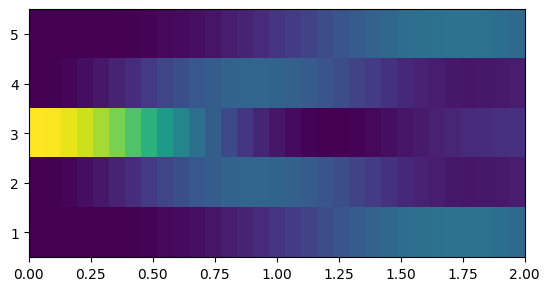

In [18]:
import qutip as qtp
import matplotlib.pyplot as plt

def draw_results(steps, results_list, show_enc_prob=False):
    rev_map = dict(zip(s, range(len(s))))
    distr = np.zeros((N, steps + 1))
    in_enc_space = np.zeros(steps + 1)
    for i, res in enumerate(results_list):
        counts = [0.] * N
        for k in res.keys():
            deck = int(k, 2)
            if deck in rev_map:
                counts[rev_map[deck]] += res[k]
        in_enc_space[i] = sum(counts)
        for j in range(N):
            distr[j, i] = counts[j] / in_enc_space[i]
    if show_enc_prob:
        print("Population in encoding subspace:", sum(in_enc_space) / len(in_enc_space))
    plt.imshow(distr, extent=[0, T, 0.5, N + 0.5], aspect=0.2)

steps = 30
ket9 = qtp.basis(1 << (N - 1), s[(N - 1) // 2])
timestep = np.linspace(0, T, steps + 1)
results_list = []
for t in timestep:
    walk = ChainWalk(N, t, g)
    qtpp.compile(walk, initial_state=ket9, verbose=-1)
    qtpp.run(verbose=-1)
    results_list.append(qtpp.results())

draw_results(steps, results_list)

### Deploying Hamiltonian embedding on QuEra devices

The above Hamiltonian $H$ may be implemented on QuEra devices. We access their devices via Braket providers.

In [38]:
from simuq.providers import BraketProvider

bp = BraketProvider()

In [39]:
walk = ChainWalk(N, T=2, g=g)
bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=2)

To drive the system into $|9\rangle$, we employ a quantum optimal control technique developed in [Differentiable Analog Quantum Computing for Optimization and Control](https://arxiv.org/abs/2210.15812) to generate global laser control pulses that generate $|9\rangle$ with 98% fidelity in ideal cases. For further coding details please refer to [Bloqade Control](https://github.com/jiaqileng/diff-analog-rydberg).

Here we import pre-trained state preparation pulses.

In [40]:
def load_state_prep(file):
    state_prep_pulse = np.load(file)
    sp_omega = state_prep_pulse.f.omega
    sp_delta = state_prep_pulse.f.delta
    sp_phi = np.zeros_like(sp_omega)
    sp_times = state_prep_pulse.f.times
    diff_sp_times = [sp_times[i + 1] - sp_times[i] for i in range(len(sp_times) - 1)]
    return {"times": diff_sp_times, "omega": sp_omega, "delta": sp_delta, "phi": sp_phi, "timeseries": sp_times}

state_prep = load_state_prep("pulses/chain_state_prep_4_qubit_ket9_high_fidelity.npz")

In [41]:
walk = ChainWalk(N, T=2, g=g)
bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=5, state_prep=state_prep, no_main_body=True)

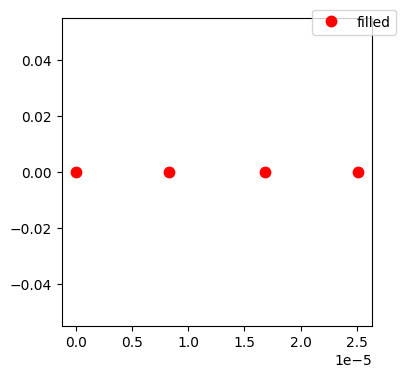

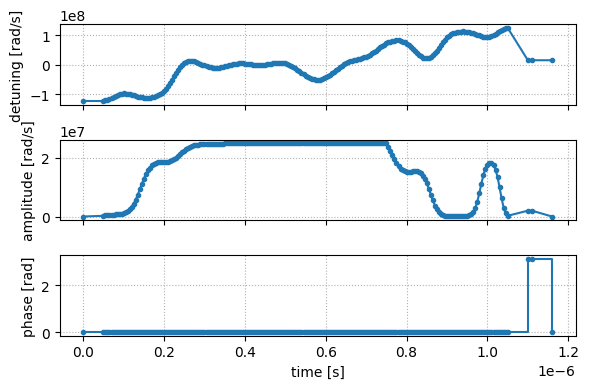

In [43]:
bp.visualize()

In [44]:
bp.run(on_simulator=True)

Submitted.


In [45]:
print(bp.results())

{'0000': 0.001, '0001': 0.008, '0011': 0.003, '0100': 0.003, '0101': 0.006, '0110': 0.003, '0111': 0.001, '1000': 0.007, '1001': 0.951, '1010': 0.012, '1011': 0.001, '1100': 0.003, '1101': 0.001}


Population in encoding subspace: 0.9463225806451612


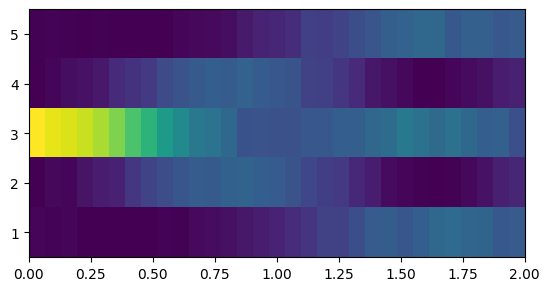

In [47]:
results_list = [bp.results()]
for t in timestep:
    if t == 0:
        continue
    walk = ChainWalk(N, t, g)
    bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=5, state_prep=state_prep)
    bp.run(on_simulator=True, verbose=-1)
    results_list.append(bp.results())
draw_results(steps, results_list, True)

We may then execute the algorithm on real devices. However, hardware restrictions limit the precision of state preparation: (1) the time intervals of pulses are wide ($\geq 0.05\mu s$); (2) the slew rates and ranges of parameters are much limited. We generate another pulse preparing $|9\rangle$ with 84% fidelity in ideal cases and can be executed on Aquila, while the performance tests are left for practice of users.

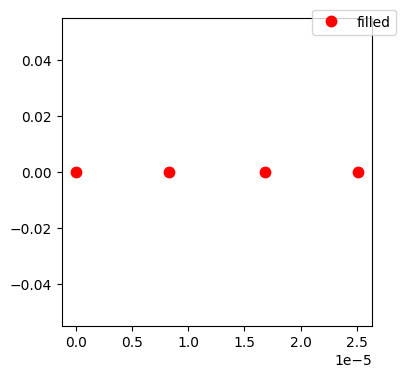

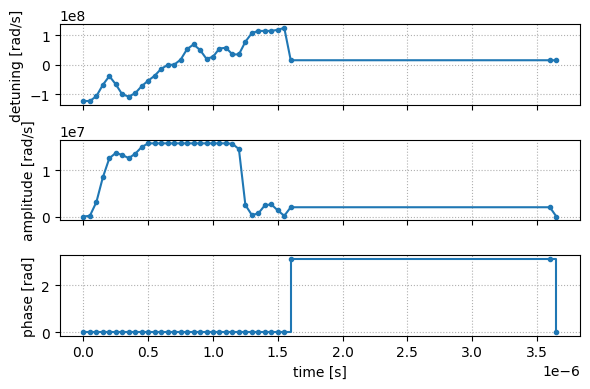

In [59]:
state_prep = load_state_prep("pulses/chain_state_prep_4_qubit_ket9_practical.npz")
state_prep_lowres = {}
for key in state_prep.keys():
    state_prep_lowres[key] = [state_prep[key][j] for j in range(0, len(state_prep[key]), 10)]
timeseries = state_prep_lowres["timeseries"]
state_prep_lowres["times"] = [timeseries[j + 1] - timeseries[j] for j in range(len(timeseries) - 1)]

bp.compile(walk, provider="quera", device="Aquila", aais="rydberg1d_global", tol=5, state_prep=state_prep_lowres)
bp.visualize()

In [60]:
bp.run(shots = 1)

Submitted.
Task arn:  arn:aws:braket:us-east-1:795824654075:quantum-task/60ee7083-e222-4f46-b85d-ed8a382d3a45
Task status:  QUEUED


### Deploy Hamiltonian embedding on IonQ devices

We can similarly deploy the Hamitlonian $H$ on IonQ devices. For state preparation on IonQ devices, we simply apply two $X$ gates to generate $|9\rangle=|1001\rangle.$ 

In [8]:
from simuq.providers import IonQProvider

ionqp = IonQProvider(from_file="../../ionq_API_key")

In [19]:
def Xgate(q) :
    gate = {"gate": "gpi", "target": q, "phase": 0.}
    return gate
state_prep = {"circuit'" [Xgate(0), Xgate(3)]}

0.44051631805354835


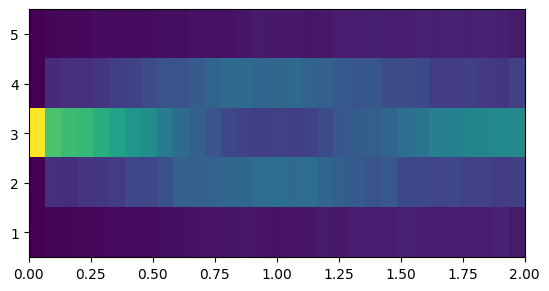

In [35]:
import time

results_list = []
for t in timestep:
    walk = ChainWalk(N, t, g)
    ionqp.compile(walk, backend="aria-1", trotter_num=14, state_prep=state_prep)
    ionqp.run(shots=4096, on_simulator=True, verbose=-1)
    while True:
        time.sleep(5)
        res = ionqp.results(verbose=-1)
        if res is not None:
            break
    results_list.append(res)

draw_results(steps, results_list, True)

The leakage outside the encoding subspace is huge, because of the noises in the above simulations. Further details on how to reduce the effects of errors are illustrated in [[arXiv:XXXX.XXXX]](), including use another embedding of $L$ into $$H = \sum\nolimits_{j=1}^{|V|} \mathrm{deg}(j)\hat{n}_j + \sum\nolimits_{(j, k)\in E} (X_j X_k+Y_jY_k)/2$$ where there is no penalty term. Notice that, for the QuEra's device, this Hamiltonian is not native and hence not applicable. The programming and deployment of $H$ on IonQ devices are similar to the above procedure.

### Deploy Hamiltonian embedding on IBM devices
We can similarly deploy the Hamitlonian $H$ on IBM devices. For state preparation on IBM devices, we simply apply two $X$ gates to generate $|9\rangle=|1001\rangle.$ 

In [ ]:
from simuq.providers import IBMProvider

ibm = IBMProvider(from_file="../../../qiskit_APIKEY", hub="ibm-q-ornl", group="ornl", project="phy147")

In [10]:
from qiskit import QuantumCircuit
state_prep=QuantumCircuit(4)
state_prep.x(0)
state_prep.x(3)

In [ ]:
results_list = []
for t in timestep:
    walk = ChainWalk(N, t, g)
    ibm.compile(walk, backend="ibmq_guadalupe", trotter_num=6,use_pulse=False, state_prep=state_prep)
    ibm.run(on_simulator=True, shots=8192)
    results_list.append(ibm.results(on_simulator=True))

draw_results(steps, results_list)